In [70]:
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob


bg_files = glob('../SegmenTron/scripts/bgs/*_1024x1024.png')
wm_files = glob('../SegmenTron/scripts/gr/*.png')


In [71]:
'''utils'''

import IPython.display as ipd


def module_helper(module_list, module_ret):
    scope = {}
    markdown = ''
    for script in module_list:
        with open(script, 'r') as f:
            text = f.read()
            markdown += f'# {os.path.basename(script)}\n```python\n{text}```\n'
            exec(text, scope)
    # print(scope.keys())
    ipd.display(ipd.Markdown(markdown))
    return (scope[m] for m in module_ret)


create_blob, CodeGenerator, multi_process_wrapper, code_generator, QRCodeEncoder = module_helper([
    '../SegmenTron/scripts/data_maker.py',
], ['create_blob', 'CodeGenerator', 'multi_process_wrapper', 'code_generator', 'QRCodeEncoder'])


# data_maker.py
```python
import cv2
import glob
import os
import traceback
from multiprocessing import Process
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import imgaug
from imgaug import augmenters as iaa
from imgaug import parameters as iap

from scipy.interpolate import interp1d
from pystrich.code128 import Code128Encoder
from pystrich.code39 import Code39Encoder
from pystrich.datamatrix import DataMatrixEncoder
from pystrich.qrcode import QRCodeEncoder


class IAS:
    bg_aug_seq = iaa.Sometimes(
        0.5,
        iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Flipud(0.5),
            iaa.Sometimes(0.5,
                          iaa.GaussianBlur(
                              sigma=iap.Uniform(
                                  0.0, 0.5)
                          ),
                          ),
            iaa.Sometimes(0.5,
                          iaa.LinearContrast(
                              iap.Choice(
                                  [1.0, 1.5, 3.0],
                                  p=[0.5, 0.3, 0.2]
                              )
                          )
                          ),
            iaa.Sometimes(0.5,
                          iaa.AdditiveGaussianNoise(loc=0, scale=(
                              0.0, 0.05 * 255), per_channel=0.5),
                          ),
            iaa.Sometimes(0.5,
                          iaa.Multiply(
                              iap.Positive(
                                  iap.Normal(0.0, 0.1)) + 1.0
                          )
                          )
        ], random_order=True))
    fg_aug_seq = iaa.Sequential([
        iaa.GaussianBlur(
            sigma=iap.Uniform(0.0, 3.0)
        ),
        iaa.LinearContrast(
            iap.Choice(
                [1.0, 1.5, 3.0],
                p=[0.5, 0.3, 0.2]
            )
        ),
        iaa.AdditiveGaussianNoise(loc=0, scale=(
            0.0, 0.05 * 255), per_channel=0.5),
        iaa.Sometimes(
            0.5,
            iaa.Multiply(
                iap.Positive(iap.Normal(0.0, 0.1)) + 1.0
            )
        ),
        iaa.pillike.EnhanceBrightness(),
        iaa.Sometimes(0.5, iaa.pillike.FilterSmoothMore()),
        iaa.JpegCompression(compression=(60, 99)),
    ], random_order=True)


def random_mirror(img):
    if npr.uniform() < 0.5:
        if npr.uniform() < 0.5:
            img = img[::-1]
        if npr.uniform() < 0.5:
            img = img[:, ::-1]
    return img


def random_line_mask(fg_mask, width, linetype, border=3):
    '''随机添加线段区域'''

    canvas = np.zeros_like(fg_mask, dtype='uint8')

    if npr.uniform() < 0.5:
        # 左上
        x1 = npr.randint(border, canvas.shape[1] // 2 - border)
        y1 = npr.randint(border, canvas.shape[0] // 2 - border)
    else:
        # 右上
        x1 = npr.randint(canvas.shape[1] // 2 +
                         border, canvas.shape[1] - border)
        y1 = npr.randint(border, canvas.shape[0] // 2 - border)

    if npr.uniform() < 0.5:
        # 左下
        x2 = npr.randint(border, canvas.shape[1] // 2 - border)
        y2 = npr.randint(canvas.shape[0] // 2 +
                         border, canvas.shape[0] - border)
    else:
        # 右下
        x2 = npr.randint(canvas.shape[1] // 2 +
                         border, canvas.shape[1] - border)
        y2 = npr.randint(canvas.shape[0] // 2 +
                         border, canvas.shape[0] - border)

    cv2.line(canvas, (x1, y1), (x2, y2), 1,
             thickness=width, lineType=linetype)

    return canvas


def random_point_mask(fg_mask, fg_rect, to_white=False, aou=0.15, max_try=50):
    '''添加随机方块'''

    blob_mask = np.zeros_like(fg_mask, dtype='uint8')
    x1, y1, x2, y2 = fg_rect

    blob = create_blob(np.random.randint(24, 56))
    b_h, b_w = blob.shape[:2]

    for _ in range(max_try):
        x1 = np.random.randint(x1, x2 - b_w - 1)
        y1 = np.random.randint(y1, y2 - b_h - 1)

        fg_roi = fg_mask[y1:y1 + b_h, x1:x1 + b_w]
        if to_white:
            fg_roi = np.bitwise_not(fg_roi)
        bitwise = np.bitwise_and(fg_roi, blob)

        # 如果blob区域和原图区域差异大于0.7
        _aou = bitwise.sum() / blob.sum()
        # print(aou)
        if _aou < aou:
            blob_mask[y1:y1 + b_h, x1:x1 + b_w] = blob
            return 0, blob_mask

    return 1, blob_mask


def create_blob(height, fluctuate_ratio=0.5, num_of_points=10, interp_kind='cubic'):
    '''
    return: blob (0: background, 1: blob)
    '''

    frame = np.ones((height, height)) * 255  # Default white background
    center = height // 2  # The center of the frame
    # Maximum radius that will fit the frame
    max_radius = center
    fluc_range = max_radius * fluctuate_ratio  # How much will the blob fluctuate

    random_radius = np.random.randint(
        max_radius - fluc_range, max_radius, num_of_points)
    # Pick random points in the range of fluctuation

    random_radius = np.concatenate((random_radius, [random_radius[0]]))
    # For the loop to be closed add the first value to the last
    thetas = np.arange(-np.pi, np.pi, 2 * np.pi / num_of_points)
    # Interval of each random point on the angle domain
    thetas = np.concatenate((thetas, [np.pi]))
    # Two pi will be equal to 0 as we added the first element also to the last in random_radius
    # so the loop will be closed.
    boundry_function = interp1d(thetas, random_radius, kind=interp_kind)
    # Create interpolation function

    x_matrix = np.zeros((height, height))
    # This matrix holds the x indices of the frame, every row is the same
    x_matrix[:, np.arange(0, height)] = np.arange(
        0 - center, height - center)
    # Here is the assignment for every row
    y_matrix = np.copy(x_matrix)
    y_matrix = y_matrix.T  # y matrix is just the transpose of the x matrix

    theta_matrix = np.arctan2(y_matrix, x_matrix)
    radius_matrix = np.sqrt((np.square(x_matrix) + np.square(y_matrix)))

    # These two matrices are angle and radius information of each point on the
    # frame

    rad_val_matrix = boundry_function(theta_matrix)
    # This returns the boundry function's radius information for each angle on the frame
    # This is actually a vectorization trick becasue in the frame the lines having the same
    # angle will have the same radius value

    frame = (rad_val_matrix > radius_matrix).astype(int)
    # This is where we decide if the point on the frame is inside or outside
    # of the boundry function

    # plt.imshow(frame, cmap='gray')  # These are to see the blobs
    # plt.show()

    return frame


def code_generator(encoder_class, min_length=4, max_length=30, cellsize=5, size=-1, chars=None):
    '''
    生成1d.2d码
    @return: numpy.array[h, w]
        0:条码区域
        1:背景区域
    '''
    count = 0
    if chars is None:
        chars = [chr(i) for i in range(33, 127)]

    while count < size or size == -1:
        try:
            length = npr.randint(min_length, max_length + 1)
            text = ''.join([npr.choice(chars) for _ in range(length)])
            encoder = encoder_class(text)

            if isinstance(encoder, (QRCodeEncoder, DataMatrixEncoder)):
                data = encoder.get_imagedata(cellsize=cellsize)
            else:
                encoder.options = {'show_label': False}
                data = encoder.get_imagedata(bar_width=cellsize)

            array = cv2.imdecode(np.frombuffer(
                data, np.uint8), cv2.IMREAD_GRAYSCALE)

            if isinstance(encoder, QRCodeEncoder):
                border = 4 * cellsize
                array = array[border:-border, border:-border]

            elif isinstance(encoder, DataMatrixEncoder):
                border = 2 * cellsize
                array = array[border:-border, border:-border]

            elif isinstance(encoder, (Code39Encoder, Code128Encoder)):
                border = 10 * cellsize
                array = array[:, border:-border]

            yield array
            count += 1
        except Exception as e:
            print(e)


def picture_generator(pic_files=None, size=-1, aug_proc=False):
    count = 0
    buffer = {}
    while count < size or size == -1:
        if pic_files is None:
            v = npr.randint(100, 255)
            dst = np.zeros((1024, 1024), dtype='uint8') + np.uint8(v)
        else:
            img_path = npr.choice(pic_files)
            if img_path not in buffer:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                buffer[img_path] = img
                dst = img.copy()
            else:
                dst = buffer[img_path].copy()
            if aug_proc:
                # 对背景做数据增广
                dst = IAS.bg_aug_seq.augment_image(dst)
        yield dst
        count += 1


class CodeGenerator(object):
    '''
    char max length: 100, fg max size = (820, 820)
    '''

    def __init__(self,
                 target_dir,
                 rng_seed,
                 start_index,
                 end_index,
                 code_class,
                 bg_files: list,
                 wm_files: list,
                 target_size=(832, 832),
                 bg_blank=True,
                 debug=False):

        np.random.seed(rng_seed)
        self._start_index = start_index
        self._debug = debug
        self._end_index = end_index
        self._target_dir = target_dir
        self._target_size = target_size
        self._fgs_gen = code_class
        self._bgs_gen = picture_generator(
            None if bg_blank else bg_files, aug_proc=True)
        self._wms_gen = picture_generator(wm_files)

    def _add_black_line(self, mixed, fg_mask, defect_mask):
        # 黑道
        # linetype = npr.choice([cv2.LINE_4, cv2.LINE_8, cv2.LINE_AA])
        line_mask = random_line_mask(fg_mask, npr.randint(4, 8), cv2.LINE_AA)

        # 只保留存在颜色差异的mask
        line_mask_keep = np.bitwise_or(np.bitwise_not(fg_mask), defect_mask)
        line_mask_keep = np.bitwise_and(line_mask_keep, line_mask)

        # 填充缺陷颜色
        black_value = npr.randint(0, int(mixed.mean() * 0.7))
        mixed = black_value * line_mask_keep + mixed * (1 - line_mask_keep)

        # 将缺陷叠加到defect_mask
        defect_mask = np.bitwise_or(defect_mask, line_mask_keep)

        if self._debug:
            fig, ax = plt.subplots(1, 3, figsize=(15, 15))
            # fig.suptitle("add_black_line")
            ax[0].imshow(mixed, cmap='gray')
            ax[1].imshow(line_mask, cmap='gray')
            ax[2].imshow(line_mask_keep, cmap='gray')
            plt.show()
            plt.close()

        return mixed, defect_mask

    def _add_white_line(self, mixed, bg, fg_mask, defect_mask):
        # 白道
        # linetype = npr.choice([cv2.LINE_4, cv2.LINE_8, cv2.LINE_AA])
        line_mask = random_line_mask(fg_mask, npr.randint(4, 8), cv2.LINE_AA)

        # 只保留存在颜色差异的mask
        line_mask_keep = np.bitwise_or(fg_mask, defect_mask)
        line_mask_keep = np.bitwise_and(line_mask_keep, line_mask)

        # 填充缺陷颜色
        white_value = npr.randint(bg.mean(), 255)
        mixed = white_value * line_mask_keep + mixed * (1 - line_mask_keep)

        # 将缺陷叠加到defect_mask
        defect_mask = np.bitwise_or(defect_mask, line_mask_keep)

        if self._debug:
            fig, ax = plt.subplots(1, 3, figsize=(15, 15))
            # fig.suptitle("add_white_line")
            ax[0].imshow(mixed, cmap='gray')
            ax[1].imshow(line_mask, cmap='gray')
            ax[2].imshow(line_mask_keep, cmap='gray')
            plt.show()
            plt.close()

        return mixed, defect_mask

    def _add_black_point(self, mixed, fg_mask, fg_rect, defect_mask):
        err, point_mask = random_point_mask(fg_mask, fg_rect)
        if err:
            print("can't make_point_mask")
            return mixed, defect_mask

        # 只保留存在颜色差异的mask
        point_mask_and = np.bitwise_or(np.bitwise_not(fg_mask), defect_mask)
        point_mask_and = np.bitwise_and(point_mask_and, point_mask)

        black_value = npr.randint(0, int(mixed.mean() * 0.7))
        mixed = black_value * point_mask_and + mixed * (1 - point_mask_and)

        # 将缺陷叠加到defect_mask
        defect_mask = np.bitwise_or(defect_mask, point_mask_and)

        if self._debug:
            fig, ax = plt.subplots(1, 3, figsize=(15, 15))
            # fig.suptitle("add_black_point")
            ax[0].imshow(mixed, cmap='gray')
            ax[1].imshow(point_mask, cmap='gray')
            ax[2].imshow(point_mask_and, cmap='gray')
            plt.show()
            plt.close()

        return mixed, defect_mask

    def _add_white_point(self, mixed, bg, fg_mask, fg_rect, defect_mask):
        err, point_mask = random_point_mask(fg_mask, fg_rect, to_white=True)
        if err:
            print("can't make_point_mask")
            return mixed, defect_mask

        # 只保留存在颜色差异的mask
        point_mask_and = np.bitwise_or(fg_mask, defect_mask)
        point_mask_and = np.bitwise_and(point_mask_and, point_mask)

        white_value = npr.randint(bg.mean(), 255)
        mixed = white_value * point_mask_and + mixed * (1 - point_mask_and)

        # 将缺陷叠加到defect_mask
        defect_mask = np.bitwise_or(defect_mask, point_mask_and)

        if self._debug:
            fig, ax = plt.subplots(1, 3, figsize=(15, 15))
            # fig.suptitle("add_black_point")
            ax[0].imshow(mixed, cmap='gray')
            ax[1].imshow(point_mask, cmap='gray')
            ax[2].imshow(point_mask_and, cmap='gray')
            plt.show()
            plt.close()

        return mixed, defect_mask

    def _add_watermark(self, mixed, fg_mask, defect_mask, and_type='black'):
        watermark = next(self._wms_gen)
        ih, iw = mixed.shape[:2]
        dh, dw = watermark.shape[:2]
        if dw > dh:
            ratio = 1.0 * iw / dw
        else:
            ratio = 1.0 * ih / dh
        watermark = cv2.resize(watermark, dsize=None, fx=ratio, fy=ratio)

        # 生成与mixed尺寸相同的mask图
        _, wm_thresh = cv2.threshold(
            watermark, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        wm_thresh = np.bitwise_not(wm_thresh)
        wm_thresh = np.uint8(np.float32(wm_thresh) / 255.0)  # 有水印：1 没水印：0
        nh, nw = wm_thresh.shape[:2]
        watermark_padded = np.zeros_like(mixed)
        watermark_mask_padded = np.zeros_like(fg_mask)
        top = (ih - nh) // 2
        left = (iw - nw) // 2
        watermark_padded[top: top + nh, left: left + nw] = watermark
        watermark_mask_padded[top: top + nh, left: left + nw] = wm_thresh

        # 寻找轮廓,生成watermark_mask
        contours, _ = cv2.findContours(
            watermark_mask_padded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        watermark_mask = np.zeros_like(watermark_mask_padded)
        keep_contours = []
        # 过滤有效轮廓
        for cnt in contours:
            hull_points = cv2.convexHull(cnt)
            length = len(hull_points)
            # 计算 轮廓面积 与 凸包面积
            cnt_area = cv2.contourArea(cnt)
            hull_area = cv2.contourArea(hull_points)
            if (hull_area > 56 or cnt_area > 56) and length > 3:
                keep_contours.append(cnt)
                cv2.fillPoly(watermark_mask, [cnt], 1)

        '''正片叠底'''
        multiply = np.uint8(np.float32(watermark_padded)
                            * np.float32(mixed) / 255.0)

        # 只保留存在颜色差异的mask
        if and_type == 'black':
            watermark_mask_and = np.bitwise_or(
                np.bitwise_not(fg_mask), defect_mask)
        else:
            multiply = 255 - multiply
            watermark_mask_and = np.bitwise_or(fg_mask, defect_mask)

        watermark_mask_and = np.bitwise_and(watermark_mask_and, watermark_mask)
        mixed = watermark_mask_and * multiply + \
            mixed * (1 - watermark_mask_and)

        # 将缺陷叠加到defect_mask
        defect_mask = np.bitwise_or(defect_mask, watermark_mask_and)

        if self._debug:
            fig, ax = plt.subplots(1, 3, figsize=(15, 15))
            # fig.suptitle(f"add {and_type} watermark")
            ax[0].imshow(watermark, cmap='gray')
            ax[1].imshow(multiply, cmap='gray')
            ax[2].imshow(watermark_mask_and, cmap='gray')
            plt.show()
            plt.close()

        return mixed, defect_mask

    def process(self):
        for i in range(self._start_index, self._end_index):
            print(i)
            try:
                fg = next(self._fgs_gen)
                bg = next(self._bgs_gen)

                mixed, fg_mask, fg_rect, bg_croped = self.random_paste(
                    bg, fg, self._target_size)

                clean = mixed.copy()
                # 存储黑色缺陷区域, 1: 有缺陷. 0: 没有缺陷
                black_defect_mask = np.zeros_like(fg_mask, dtype='uint8')
                # 存储白色缺陷区域, 1: 有缺陷. 0: 没有缺陷
                white_defect_mask = np.zeros_like(fg_mask, dtype='uint8')

                prob = 0.5

                # 黑道
                if npr.uniform() < prob:
                    prob -= 0.1
                    for _ in range(npr.randint(1, 4)):
                        mixed, black_defect_mask = self._add_black_line(
                            mixed, fg_mask, black_defect_mask)
                else:
                    prob += 0.1

                # 白道
                if npr.uniform() < prob:
                    prob -= 0.1
                    for _ in range(npr.randint(1, 4)):
                        mixed, white_defect_mask = self._add_white_line(
                            mixed, bg_croped, fg_mask, white_defect_mask)
                else:
                    prob += 0.1

                # 黑点
                if npr.uniform() < prob:
                    prob -= 0.1
                    for _ in range(npr.randint(1, 4)):
                        mixed, black_defect_mask = self._add_black_point(
                            mixed, fg_mask, fg_rect, black_defect_mask
                        )
                else:
                    prob += 0.1

                # 白点
                if npr.uniform() < prob:
                    prob -= 0.1
                    for _ in range(npr.randint(1, 4)):
                        mixed, white_defect_mask = self._add_white_point(
                            mixed, bg, fg_mask, fg_rect, white_defect_mask
                        )
                else:
                    prob += 0.1

                # 水印
                if npr.uniform() < 0.5:
                    watermark_method = npr.choice(['black_dust', 'white_dust'])
                    if watermark_method == 'black_dust':
                        # 黑水印
                        mixed, black_defect_mask = self._add_watermark(
                            mixed, fg_mask, black_defect_mask, 'black')
                    else:
                        # 白水印
                        mixed, white_defect_mask = self._add_watermark(
                            mixed, fg_mask, white_defect_mask, 'white')

                if npr.uniform() < 0.75:
                    mixed = IAS.fg_aug_seq.augment_image(mixed)

                defect_mask = np.bitwise_or(
                    black_defect_mask, white_defect_mask)
                # print(np.unique(defect_mask))
                defect_label = np.zeros_like(defect_mask) + 255
                defect_label[np.where(fg_mask == 1)] = 0
                defect_label[np.where(defect_mask == 1)] = 127

                if self._debug:
                    print('fg:', fg.shape)
                    print('bg:', bg.shape)
                    fig, ax = plt.subplots(2, 2, figsize=(15, 15))
                    # fig.suptitle("fg & mixed & fg_mask")
                    ax[0][0].imshow(clean, cmap='gray')
                    ax[0][1].imshow(mixed, cmap='gray')
                    ax[1][0].imshow(defect_mask, cmap='gray')
                    ax[1][1].imshow(defect_label, cmap='gray')
                    plt.show()
                    plt.close()

                    break

                if len(self._target_dir) > 0:
                    cv2.imwrite(f'{self._target_dir}/{i}_clean.png', clean)
                    cv2.imwrite(f'{self._target_dir}/{i}_defect.png', mixed)
                    cv2.imwrite(
                        f'{self._target_dir}/{i}_mask.png', defect_label)
                print(f'{self._target_dir}/{i}_clean.png')

            except Exception as e:
                traceback.print_exc()
                continue

    @staticmethod
    def random_paste(bg, fg, dst_size):
        '''
        @bg: 单通道图像
        @fg: 单通道mask图,0表示白色,1表示黑色
        @return: 
            mixed: 背景和code码混合图             (裁剪后)
            fg_mask: 掩码图, 1为条码黑, 0为背景白  (裁剪后)
            fg_rect: 掩码在bg_croped中的区域      (裁剪后)
            bg_croped: 从背景图上扣出的区域
        '''

        bg_h, bg_w = bg.shape[:2]
        fg_h, fg_w = fg.shape[:2]
        dt_h, dt_w = dst_size

        assert fg_w < bg_w and fg_h < bg_h, ValueError("bg size > fg size")
        assert dt_h < bg_h and dt_w < bg_w, ValueError("bg size > dst size")
        assert fg_w < dt_w and fg_h < dt_h, ValueError("dst size > fg size")

        # 从bg上裁剪一块指定大小区域
        x1 = np.random.randint(0, bg_w - dt_w + 1)
        y1 = np.random.randint(0, bg_h - dt_h + 1)
        x2 = x1 + dt_w
        y2 = y1 + dt_h
        bg_croped = bg[y1:y2, x1:x2].copy()

        # 对前景进行增广
        # fg_aug = ImgAugSeq.fg_aug_seq.augment_image(fg.copy())

        # fg mask roi, 1为条码黑，0为背景白
        fg_mask_roi = np.zeros_like(fg)
        fg_mask_roi[np.where(fg == 0)] = 1

        # 从裁剪后的bg确定一块放置fg的区域
        xx1 = np.random.randint(0, dt_w - fg_w)
        yy1 = np.random.randint(0, dt_h - fg_h)
        xx2 = xx1 + fg_w
        yy2 = yy1 + fg_h
        bg_roi = bg_croped[yy1:yy2, xx1:xx2].copy()

        # 将fg二维码与bg区域混合
        bg_roi = bg_roi * (1 - fg_mask_roi) + fg * fg_mask_roi

        # 将fg二维码放置到裁剪后区域
        mixed = bg_croped.copy()
        mixed[yy1:yy2, xx1:xx2] = bg_roi

        # 将fg mask对齐到整个裁剪区域
        fg_mask = np.zeros_like(bg_croped, dtype='uint8')
        fg_mask[yy1:yy2, xx1:xx2] = fg_mask_roi

        fg_rect = (xx1, yy1, xx2, yy2)

        return mixed, fg_mask, fg_rect, bg_croped


def multi_process_wrapper(target_dir, bg_files, wm_files, num_samples, num_worker, code_class):

    if code_class == 'QRCodeEncoder':
        # char max length: 100, fg max size = (820, 820)
        cg = code_generator(QRCodeEncoder, min_length=3,
                            max_length=100, cellsize=20, size=-1)
        target_size = (832, 832)
    elif code_class == 'Code128Encoder':
        # char max length: 25, fg max size = (330, 930)
        cg = code_generator(Code128Encoder, min_length=3,
                            max_length=25, cellsize=3, size=-1)
        target_size = (384, 960)
    elif code_class == 'Code39Encoder':
        # char max length: 20, fg max size = (120, 855)
        chars = list('1234567890ABCDEFGHIJKLMNOPQRSTUVWXYZ-. *$/+%')
        cg = code_generator(Code39Encoder, min_length=2,
                            max_length=20, cellsize=3, size=-1, chars=chars)
        target_size = (384, 960)
    elif code_class == 'DataMatrixEncoder':
        # char max length: 100, fg max size = (800, 800)
        cg = code_generator(DataMatrixEncoder, min_length=3,
                            max_length=100, cellsize=20, size=-1)
        target_size = (832, 832)
    else:
        NotImplementedError(code_class)

    def _wrapper(rng_seed, start_index, end_index):
        imgaug.seed(rng_seed)
        cg_class = CodeGenerator(
            target_dir=target_dir,
            rng_seed=rng_seed,
            start_index=start_index,
            end_index=end_index,
            code_class=cg,
            bg_files=bg_files,
            wm_files=wm_files,
            target_size=target_size,
            bg_blank=False,
            debug=False
        )
        cg_class.process()

    num_split = num_samples // num_worker
    procs = [
        Process(target=_wrapper, args=(
            int(i * 1234),
            int(num_split * i),
            int(num_split * (i + 1))
        ))
        for i in range(num_worker)
    ]
    return procs
```


[0 1]


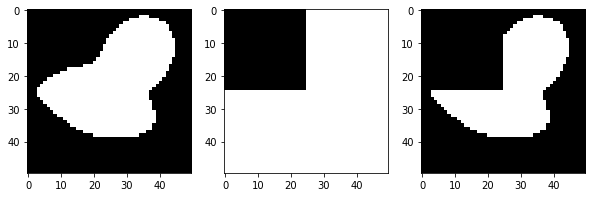

In [72]:
blob = create_blob(np.random.randint(10, 56))
print(np.unique(blob))

mask = np.zeros_like(blob)
mask[:mask.shape[0]//2, :mask.shape[1]//2] = 1
mask = np.bitwise_not(mask)
bitwise = np.bitwise_and(blob, mask)

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(blob, cmap='gray')
ax[1].imshow(mask, cmap='gray')
ax[2].imshow(bitwise, cmap='gray')  # These are to see the blobs
plt.show()


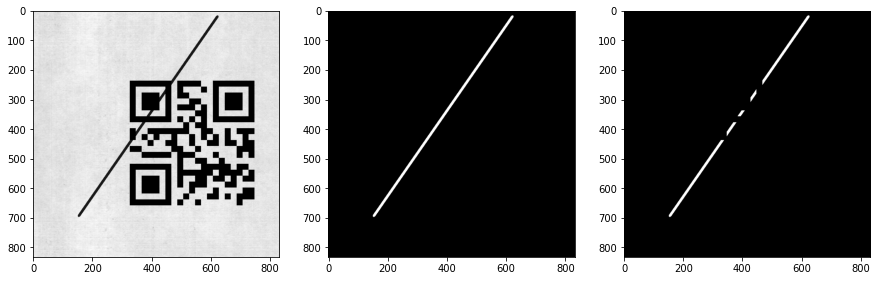

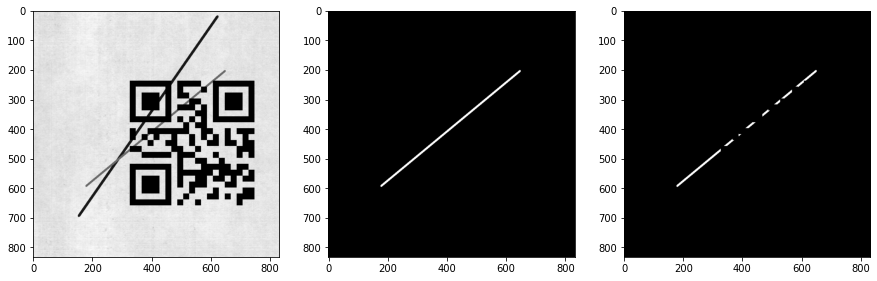

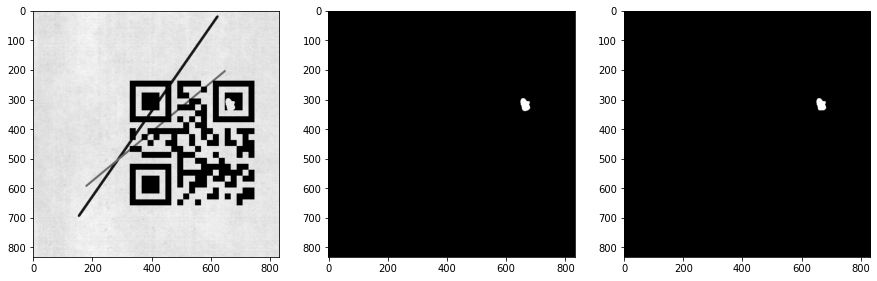

can't make_point_mask


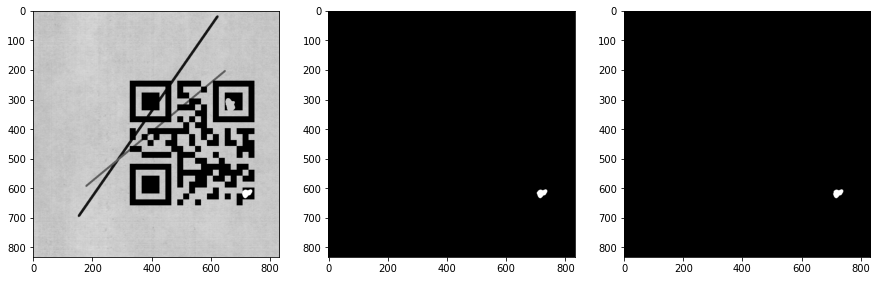

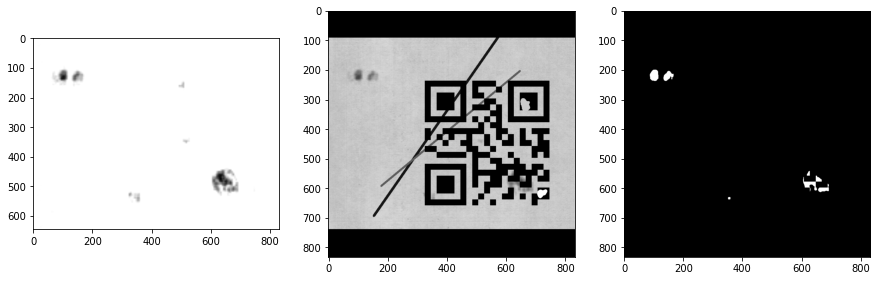

fg: (420, 420)
bg: (1024, 1024)


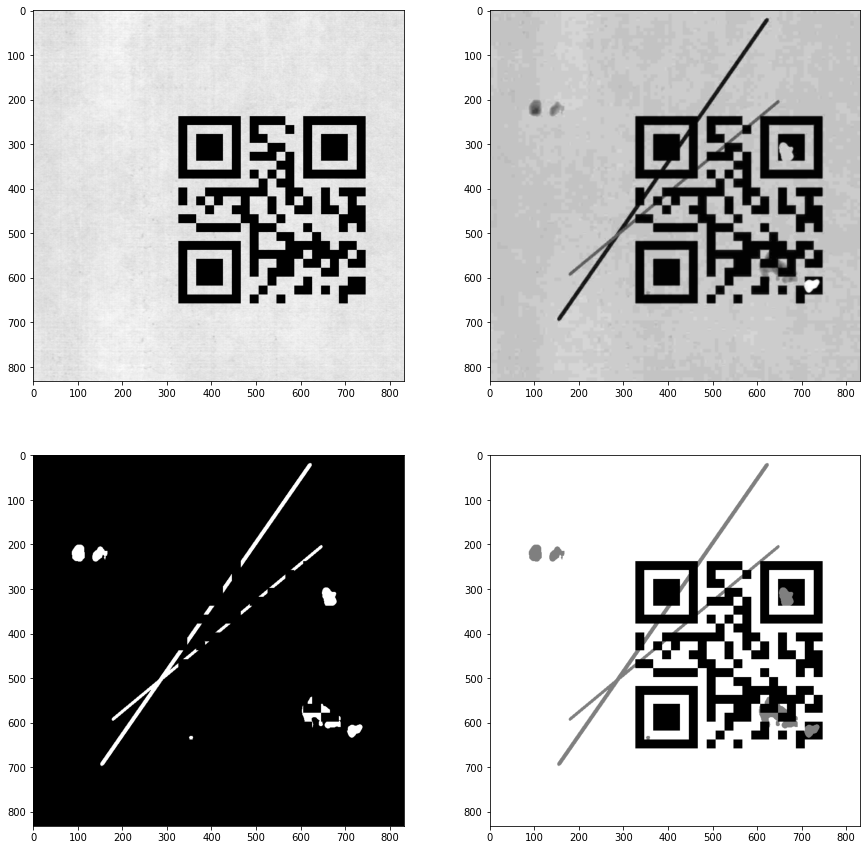

In [38]:
import time
cg = CodeGenerator(
    target_dir='',
    rng_seed=int(time.time()),
    start_index=0,
    end_index=100,
    code_class=code_generator(
        QRCodeEncoder, min_length=3, max_length=100, cellsize=20, size=-1),
    bg_files=bg_files,
    wm_files=wm_files,
    target_size=(832, 832),
    bg_blank=False,
    debug=True
)
cg.process()